<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#List-of-Tenders-(Ausschreibung)" data-toc-modified-id="List-of-Tenders-(Ausschreibung)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>List of Tenders (Ausschreibung)</a></span></li><li><span><a href="#Result-of-Tenders-(Abgegebene-Angebote-/-Allocated-SRL)" data-toc-modified-id="Result-of-Tenders-(Abgegebene-Angebote-/-Allocated-SRL)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Result of Tenders (Abgegebene Angebote / Allocated SRL)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Supply/Demand-Curve-according-to-bids-and-asks-(According-to-Kahlen)" data-toc-modified-id="Supply/Demand-Curve-according-to-bids-and-asks-(According-to-Kahlen)-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Supply/Demand Curve according to bids and asks (According to Kahlen)</a></span></li></ul></li></ul></li><li><span><a href="#Activated-Control-Reserve-from-regelleistungen.net" data-toc-modified-id="Activated-Control-Reserve-from-regelleistungen.net-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Activated Control Reserve from regelleistungen.net</a></span></li><li><span><a href="#Clearing-Prices-of-Secondary-Reserve" data-toc-modified-id="Clearing-Prices-of-Secondary-Reserve-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clearing Prices of Secondary Reserve</a></span></li><li><span><a href="#Validate-Numbers" data-toc-modified-id="Validate-Numbers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validate Numbers</a></span></li><li><span><a href="#SMARD-Data" data-toc-modified-id="SMARD-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SMARD Data</a></span><ul class="toc-item"><li><span><a href="#Average-activated-price-vs-clearing-price" data-toc-modified-id="Average-activated-price-vs-clearing-price-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Average activated price vs clearing price</a></span></li></ul></li></ul></div>

In [1]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# List of Tenders (Ausschreibung)

__Use for bidding time for agent__

In [3]:
df_tenders = pd.read_csv("../data/raw/balancing/tenders_2016_2017.csv", sep=';', index_col=False,
                         dayfirst=True, parse_dates=[0, 1, 2, 3, 4], infer_datetime_format=True, decimal=',')
df_tenders = df_tenders[['DATE_FROM', 'DATE_TO', 'GATE_OPEN_TIME',
                         'GATE_COSURE_TIME', 'PRODUCT', 'TOTAL_DEMAND_[MW]']]
df_tenders.columns = ['from', 'to', 'gate_opening',
                      'gate_closure', 'product', 'demand_mw']
df_tenders.head(10)

,from,to,gate_opening,gate_closure,product,demand_mw
0,2015-12-28,2016-01-03,2015-12-18 12:00:00,2015-12-22 15:00:00,NEG_HT,2500
1,2015-12-28,2016-01-03,2015-12-18 12:00:00,2015-12-22 15:00:00,NEG_NT,2500
2,2015-12-28,2016-01-03,2015-12-18 12:00:00,2015-12-22 15:00:00,POS_HT,2500
3,2015-12-28,2016-01-03,2015-12-18 12:00:00,2015-12-22 15:00:00,POS_NT,2500
4,2016-01-04,2016-01-10,2015-12-23 12:00:00,2015-12-29 15:00:00,NEG_HT,1979
5,2016-01-04,2016-01-10,2015-12-23 12:00:00,2015-12-29 15:00:00,NEG_NT,1979
6,2016-01-04,2016-01-10,2015-12-23 12:00:00,2015-12-29 15:00:00,POS_HT,2054
7,2016-01-04,2016-01-10,2015-12-23 12:00:00,2015-12-29 15:00:00,POS_NT,2054
8,2016-01-11,2016-01-17,2015-12-30 12:00:00,2016-01-05 15:00:00,NEG_HT,1979
9,2016-01-11,2016-01-17,2015-12-30 12:00:00,2016-01-05 15:00:00,NEG_NT,1979


# Result of Tenders (Abgegebene Angebote / Allocated SRL)

Double checked with e.g. 
- https://www.smard.de/blueprint/servlet/page/home/marktdaten/78?marketDataAttributes=%7B%22resolution%22:%22week%22,%22region%22:%22DE%22,%22from%22:1509490800000,%22to%22:1512945900000,%22moduleIds%22:%5B18000422,18000423%5D,%22selectedCategory%22:null,%22activeChart%22:true,%22language%22:%22de%22%7D#chart-legend

**Caution: When aggregating take into account not to sum up HT and NT!**

In [4]:
df_results = pd.read_csv("../data/processed/tender_results.csv",
                         parse_dates=[0, 1], infer_datetime_format=True)
df_results.head(10)

,from,to,capacity_price_mw,energy_price_mwh,offered_mw,allocated_mw,product_type,product_time,cumsum_allocated_mw
0,2015-12-28,2016-01-03,633.0,1.0,5,5,NEG,HT,5
1,2015-12-28,2016-01-03,504.0,-0.5,10,10,NEG,HT,15
2,2015-12-28,2016-01-03,643.0,-4.0,12,12,NEG,HT,27
3,2015-12-28,2016-01-03,520.0,-5.9,10,10,NEG,HT,37
4,2015-12-28,2016-01-03,567.0,-5.9,20,20,NEG,HT,57
5,2015-12-28,2016-01-03,583.0,-5.9,20,20,NEG,HT,77
6,2015-12-28,2016-01-03,615.0,-5.9,20,20,NEG,HT,97
7,2015-12-28,2016-01-03,499.0,-6.5,10,10,NEG,HT,107
8,2015-12-28,2016-01-03,599.0,-7.5,20,20,NEG,HT,127
9,2015-12-28,2016-01-03,653.0,-8.0,12,12,NEG,HT,139


### Supply/Demand Curve according to bids and asks (According to Kahlen)

**Kahlen:** _The data for Stuttgart contains the individual bids and asks with the respective quantities and prices for each 15-minute time interval. From these bids and asks we form the demand and supply curves. The clearing point Q∗ sets the equilibrium, which determines whether the energy market operator settles the asks and bids placed by FleetPower (if the price P from the model is below the market price_ (P.71, Diss)

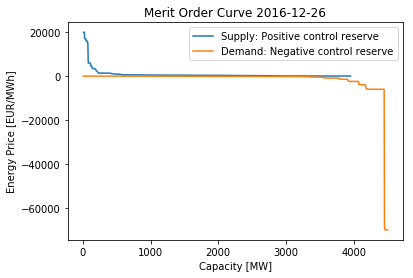

In [6]:
time = "HT"
day = "2016-12-26"
df_plot = df_results.loc[(df_results["product_time"]
                          == time) & (df_results["from"] == day)]

df_supply = df_plot.loc[df_plot["product_type"] == "POS"].sort_values(
    ["energy_price_mwh"], ascending=False).copy()
df_supply["cum_capacity_mw"] = df_supply["allocated_mw"].cumsum()
df_supply.reset_index()

df_demand = df_plot.loc[df_plot["product_type"] ==
                        "NEG"].sort_values(["energy_price_mwh"], ascending=False).copy()
df_demand["cum_capacity_mw"] = df_demand["allocated_mw"].cumsum()
df_demand.reset_index

fig, ax = plt.subplots()
plt.plot(df_supply.cum_capacity_mw, df_supply.energy_price_mwh,
         label='Supply: Positive control reserve')
plt.plot(df_demand.cum_capacity_mw, df_demand.energy_price_mwh,
         label='Demand: Negative control reserve')
ax.set_xlabel("Capacity [MW]")
ax.set_ylabel("Energy Price [EUR/MWh]")
plt.title('Merit Order Curve %s' % day)
plt.legend()
plt.show()


df_cp = pd.concat([df_supply, df_demand]).sort_values(
    "cum_capacity_mw").reset_index()
ask = float("inf")
bid = 0
for price in df_cp.itertuples():
    if price.product_type == "POS":
        ask = price.energy_price_mwh
    else:
        bid = price.energy_price_mwh

    if bid > ask:
        print('Clearing Price: %s EUR/MWh' % bid)
        break

 **This is not an Auction where participants place bids & ask, the system operator plays the other part. Also not in 15min slots, how to get clearing price??**

# Activated Control Reserve from regelleistungen.net

In [24]:
df_activated = pd.read_csv("../data/processed/activated_control_reserve.csv",
                           parse_dates=[0], infer_datetime_format=True)
df_activated.head(10)

,from,to,neg_mw,pos_mw
0,2016-01-01 00:00:00,2016-01-01 00:15:00,410.975,2.539
1,2016-01-01 00:15:00,2016-01-01 00:30:00,55.032,22.449
2,2016-01-01 00:30:00,2016-01-01 00:45:00,4.382,253.844
3,2016-01-01 00:45:00,2016-01-01 01:00:00,10.581,71.016
4,2016-01-01 01:00:00,2016-01-01 01:15:00,14.533,104.270
5,2016-01-01 01:15:00,2016-01-01 01:30:00,13.878,72.554
6,2016-01-01 01:30:00,2016-01-01 01:45:00,27.014,17.797
7,2016-01-01 01:45:00,2016-01-01 02:00:00,53.210,5.589
8,2016-01-01 02:00:00,2016-01-01 02:15:00,3.614,285.523
9,2016-01-01 02:15:00,2016-01-01 02:30:00,11.799,75.228


# Clearing Prices of Secondary Reserve

__Calculated assumed 15-min clearing prices for negative control reserve by looking at actual activated reserve__

In [36]:
from vppsim.data import load_balancing_data

df_clearing_prices = load_balancing_data()
df_clearing_prices.head()

,from,to,capacity_mw,clearing_price
0,2016-01-01 00:00:00,2016-01-01 00:15:00,410.975,-96.0
1,2016-01-01 00:15:00,2016-01-01 00:30:00,55.032,-25.0
2,2016-01-01 00:30:00,2016-01-01 00:45:00,4.382,-2.5
3,2016-01-01 00:45:00,2016-01-01 01:00:00,10.581,-13.0
4,2016-01-01 01:00:00,2016-01-01 01:15:00,14.533,-13.0


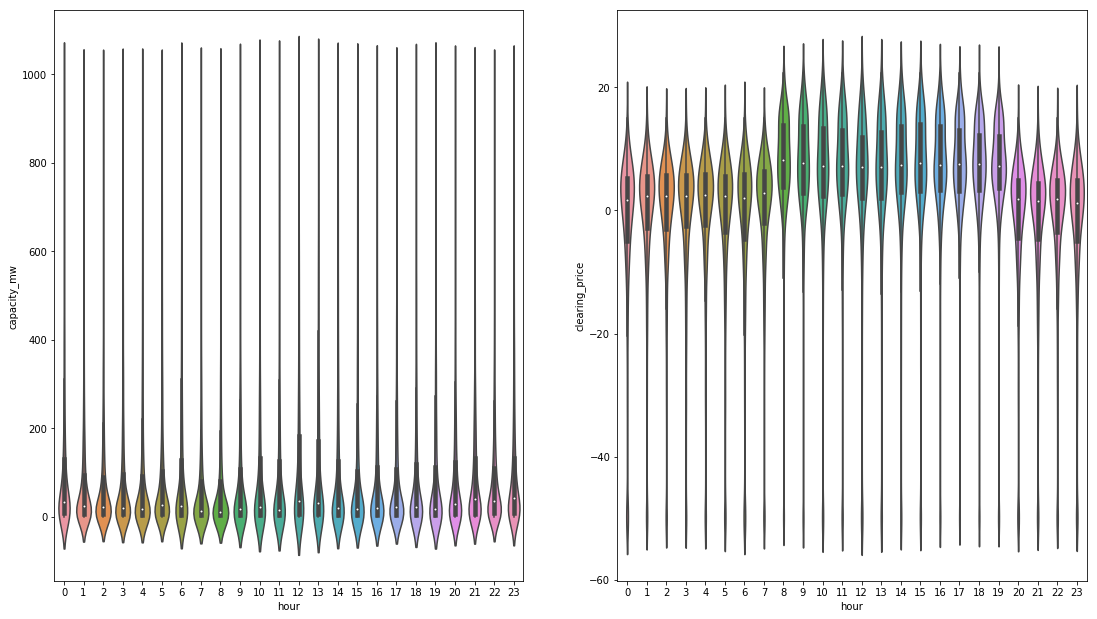

In [41]:
df_clearing_prices["day"] = df_clearing_prices["from"].dt.weekday
df_clearing_prices["hour"] = df_clearing_prices["from"].dt.hour
df_clearing_prices.loc[df_clearing_prices["clearing_price"] < -50, "clearing_price"] = -50
df_clearing_prices.loc[df_clearing_prices["capacity_mw"] > 1000, "capacity_mw"] = 1000

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
sns.violinplot(x="hour", y="capacity_mw", data=df_clearing_prices, ax=ax1)
sns.violinplot(x="hour", y="clearing_price", data=df_clearing_prices, ax=ax2)

# Validate Numbers

_"Laut Monitoring-Bericht 2017 der Bundesnetzagentur betrug im Jahr 2016 die abgerufene Energiemenge in der negativen Sekundärreserve (SRL) 0,7 TWh sowie 1,4 TWh für die positive SRL"_

-- https://www.next-kraftwerke.de/wissen/regelenergie

-- https://www.smard.de/blueprint/servlet/page/home/marktdaten/78?marketDataAttributes=%7B%22resolution%22:%22year%22,%22region%22:%22DE%22,%22from%22:1451602800000,%22to%22:1514846700000,%22moduleIds%22:%5B18000427,18000426%5D,%22selectedCategory%22:18,%22activeChart%22:true,%22language%22:%22de%22%7D#chart-legend

Also shows this

In [41]:
# Aggregated activated is in 15-min intervals, divide by 4 to get TWh
activated_neg_2016 = df_activated[df_activated["from"] < datetime(
    2017, 1, 1)].neg_mw.sum() / 1000000 / 4
activated_pos_2016 = df_activated[df_activated["from"] < datetime(
    2017, 1, 1)].pos_mw.sum() / 1000000 / 4

print('Activated Control Reserve 2016 - Negative : %.2f TWh Positive %.2f TWh' %
      (activated_neg_2016, activated_pos_2016))

Activated Control Reserve 2016 - Negative : 0.71 TWh Positive 1.41 TWh


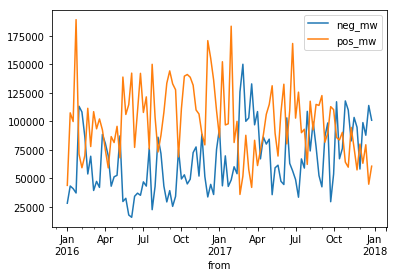

In [27]:
df_activated.set_index("from").groupby(pd.Grouper(freq='W')).sum().plot()

# SMARD Data

SMARD: _Für die Sekundärregelung vorgehaltene Leistung bzw. Menge [MW], der durchschnittliche Leistungspreis der bezuschlagten Angebote [€/MW], die durchschnittlich abgerufene Leistung bzw. Menge [MWh] und der durchschnittliche Arbeitspreis aller jeweils aktivierten Angebote [€/MWh]_

In [35]:
df_smard = pd.read_csv("../data/raw/balancing/de_activated_srl_2016_2017.csv", sep=';', index_col=False,
                         dayfirst=True, parse_dates=[0], infer_datetime_format=True)
df_smard.columns=["date", "time", "acitvated_pos_mwh", "activated_neg_mwh", "energy_price_pos", "energy_price_neg", "allocated_pos_mw", "allocated_neg_mw", "capacity_price_pos", "capacity_price_neg"]


# Merge date and time columns
df_smard["date"] = pd.to_datetime(
    df_smard["date"].astype(str)
    + " "
    + df_smard["time"].astype(str)
)

df_smard.drop("time", axis=1, inplace=True)
df_smard.head()

,date,acitvated_pos_mwh,activated_neg_mwh,energy_price_pos,energy_price_neg,allocated_pos_mw,allocated_neg_mw,capacity_price_pos,capacity_price_neg
0,2016-01-01 00:00:00,0.25,103.25,49.05,-41.94,2500,2500,951.68,1273.95
1,2016-01-01 00:15:00,7.00,15.25,52.08,-19.79,2500,2500,951.68,1273.95
2,2016-01-01 00:30:00,64.75,2.50,58.69,-7.91,2500,2500,951.68,1273.95
3,2016-01-01 00:45:00,18.75,4.00,53.66,-9.79,2500,2500,951.68,1273.95
4,2016-01-01 01:00:00,27.00,4.50,54.42,-10.67,2500,2500,951.68,1273.95


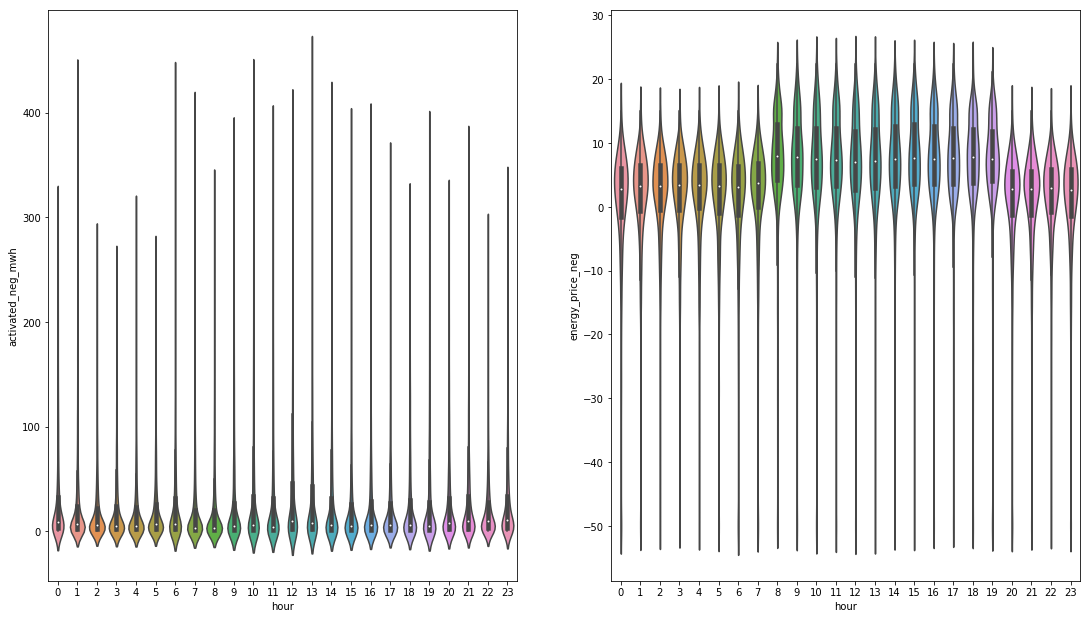

In [38]:
df_smard["day"] = df_smard["date"].dt.weekday
df_smard["hour"] = df_smard["date"].dt.hour

# Cap energy prices for better plot visibility
df_smard.loc[df_smard["energy_price_neg"] < -50, "energy_price_neg"] = -50
#df_smard.loc[df_smard["capacity_mw"] > 1000, "capacity_mw"] = 1000

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
sns.violinplot(x="hour", y="activated_neg_mwh", data=df_smard, ax=ax1)
sns.violinplot(x="hour", y="energy_price_neg", data=df_smard, ax=ax2)

## Average activated price vs clearing price

In [45]:
# Difference between average and clearing price
df_smard.groupby("hour")["energy_price_neg"].mean() - df_clearing_prices.groupby("hour")["clearing_price"].mean()

hour
0     3.077134
1     2.542702
2     2.358917
3     2.550617
4     2.372620
5     2.753773
6     2.760449
7     1.942252
8     0.567616
9     0.800324
10    1.172342
11    1.103523
12    1.873333
13    1.268783
14    1.051412
15    1.116538
16    0.965217
17    0.877571
18    1.069372
19    0.812213
20    2.819347
21    3.073551
22    2.785709
23    2.984623
dtype: float64

- Average price for activated energy is higher than clearing price. 
- TSO wants the provider to pay higher prices
- If we bid _higher_ than clearing price our bid will get accepted!